# mode choice models: v1 (prescription medications)

Reminder about parameter coding: 
- drone choice=1
- ground choice=0

Prescription medications are tricky for the model because of their attribute level values.

Delivery wait time:
- 30 minutes
- 2 hrs (120 minutes)
- 6 hrs (360 minutes)
- 1 day (1440 minutes)


---

##### Warning about this notebook:

- A key library used in this notebook is Biogeme.
- Initially this work was using an earlier version of Biogeme.
- After reviews came back we updated the notebooks to include race demographics. 
- To run new models we needed to reinstall Biogeme. 
- **The Biogeme API changed in ways not backwards compatible**
- This notebook essentially uses both Biogeme versions
    - this is because we only ran new models to ensure race did not play a significant role
    - when this was verified, we did not rerun the final models

In [14]:
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


transformed_data_filepath = './choice-model-data-long.csv'

In [15]:
choices_df = pd.read_csv(transformed_data_filepath)
choices_df.head()

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,g_cost,d_cost,g_time,d_time,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,0,0,20,15,0,1,1,-5,0,0
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,3,0,20,20,0,0,1,0,-3,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,0,3,45,20,0,1,0,-25,3,0
3,R_3dNdOyEHwO3X5Tg,CHOICE_v1_gc3_gt0_dc0_dt2_dp0_1.1,1,1,3,0,0,2,0,1,...,10,0,30,360,0,0,1,330,-10,0
4,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc3_gt3_dc0_dt3_dp0_1.1,1,2,3,3,0,3,0,1,...,5,0,45,45,0,0,1,0,-5,0


### Add values to the choice question parameters



In [16]:
import sys  
sys.path.insert(0, '../survey-questions')

from attributes import (
    VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS,
)
for levels in [VENDOR_TYPES, COST_LEVELS, TIME_LEVELS, DRONE_PRIVACY_LEVELS]:
    print(levels)

[('take-out food', 'take-out food'), ('prescription medications', 'prescription medications'), ('liquor store', 'items from a liquor store'), ('last-minute groceries', 'last-minute groceries')]
[[(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (5, '$5'), (10, '$10')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')], [(0, '$0'), (1, '$1'), (3, '$3'), (5, '$5')]]
[[(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(30, '30 minutes'), (120, '2 hrs'), (360, '6 hrs'), (1440, '1 day')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')], [(15, '15 minutes'), (20, '20 minutes'), (30, '30 minutes'), (45, '45 minutes')]]
[(0, 'NO privacy'), (1, 'YES privacy')]


## Different for v1: Add in extra columns evaluating trade-offs for time level

Here we consider the difference in levels of time, vs minute values

In [17]:
choices_df['dt_less_gt'] = choices_df['dt'] - choices_df['gt']
choices_df.head(3)

,ResponseId,QID,choice,v,gc,gt,dc,dt,dp,male,...,d_cost,g_time,d_time,d_privacy,g_free,d_free,d_time - g_time,d_cost - g_cost,ID,dt_less_gt
0,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc0_gt1_dc0_dt0_dp0_1.1,1,2,0,1,0,0,0,1,...,0,20,15,0,1,1,-5,0,0,-1
1,R_3dNdOyEHwO3X5Tg,CHOICE_v2_gc2_gt1_dc0_dt1_dp0_1.1,1,2,2,1,0,1,0,1,...,0,20,20,0,0,1,0,-3,0,0
2,R_3dNdOyEHwO3X5Tg,CHOICE_v0_gc0_gt3_dc2_dt1_dp0_1.1,0,0,0,3,2,1,0,1,...,3,45,20,0,1,0,-25,3,0,-2


In [18]:
color_ground = 'blue'
color_drone = 'red'

def plot_points_tradeoff_by_size(df, vendor, use_levels=False):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=200)
    for dp, privacy in enumerate(DRONE_PRIVACY_LEVELS):
        ax = axes[dp]
        df_p = df[df['dp']==dp]
        time_diff_col = 'dt_less_gt' if use_levels else 'd_time - g_time'
        df_p_agg = df_p[df_p['choice']==0].groupby(
            [time_diff_col,'d_cost - g_cost']
        )['ResponseId'].count().rename('ground').to_frame()
        df_p_agg['drone'] = df_p_agg.index.map(df_p[df_p['choice']==1].groupby(
            [time_diff_col,'d_cost - g_cost']
        )['ResponseId'].count())
        df_p_agg = df_p_agg.reset_index()
        ax.scatter(
            df_p_agg[time_diff_col],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['ground'],
            color=color_ground, alpha=0.5, label='choice: ground vehicle',
            marker='o',
        )
        ax.scatter(
            df_p_agg[time_diff_col],
            df_p_agg['d_cost - g_cost'],
            df_p_agg['drone'],
            color=color_drone, alpha=0.5, label='choice: drone',
            marker='o',
        )   
        x_label = 'time level difference' if use_levels else 'drone wait time - ground vehicle wait time (mins)'
        ax.set_xlabel(x_label)
        ax.set_ylabel('drone cost - ground vehicle cost (\$)')
        ax.axvline(c='grey', lw=1)
        _ = ax.axhline(c='grey', lw=1)
        _ = ax.set_title(privacy[1])
        ax.legend()
    title = ('%s: Ground vehicle vs Drone choice differences w.r.t. cost and time' % vendor)
    _ = fig.suptitle(title)

## Focus on v1 : prescription medications

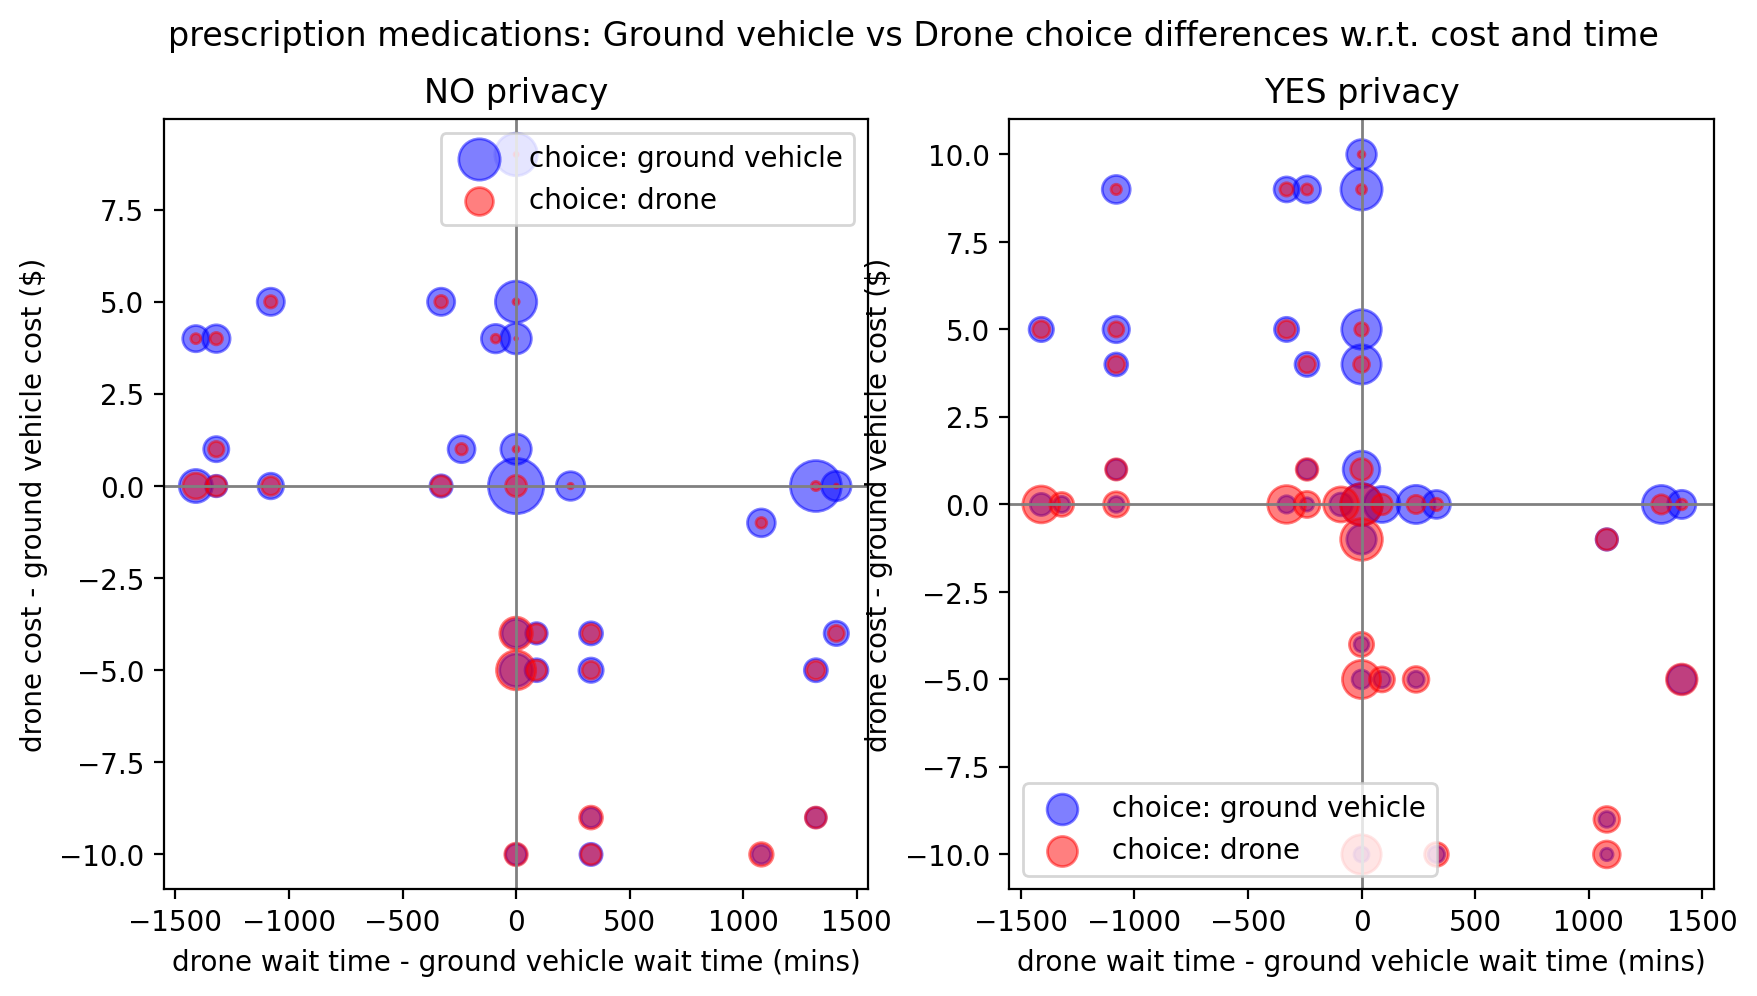

by difference in levels of time increments vs actual time


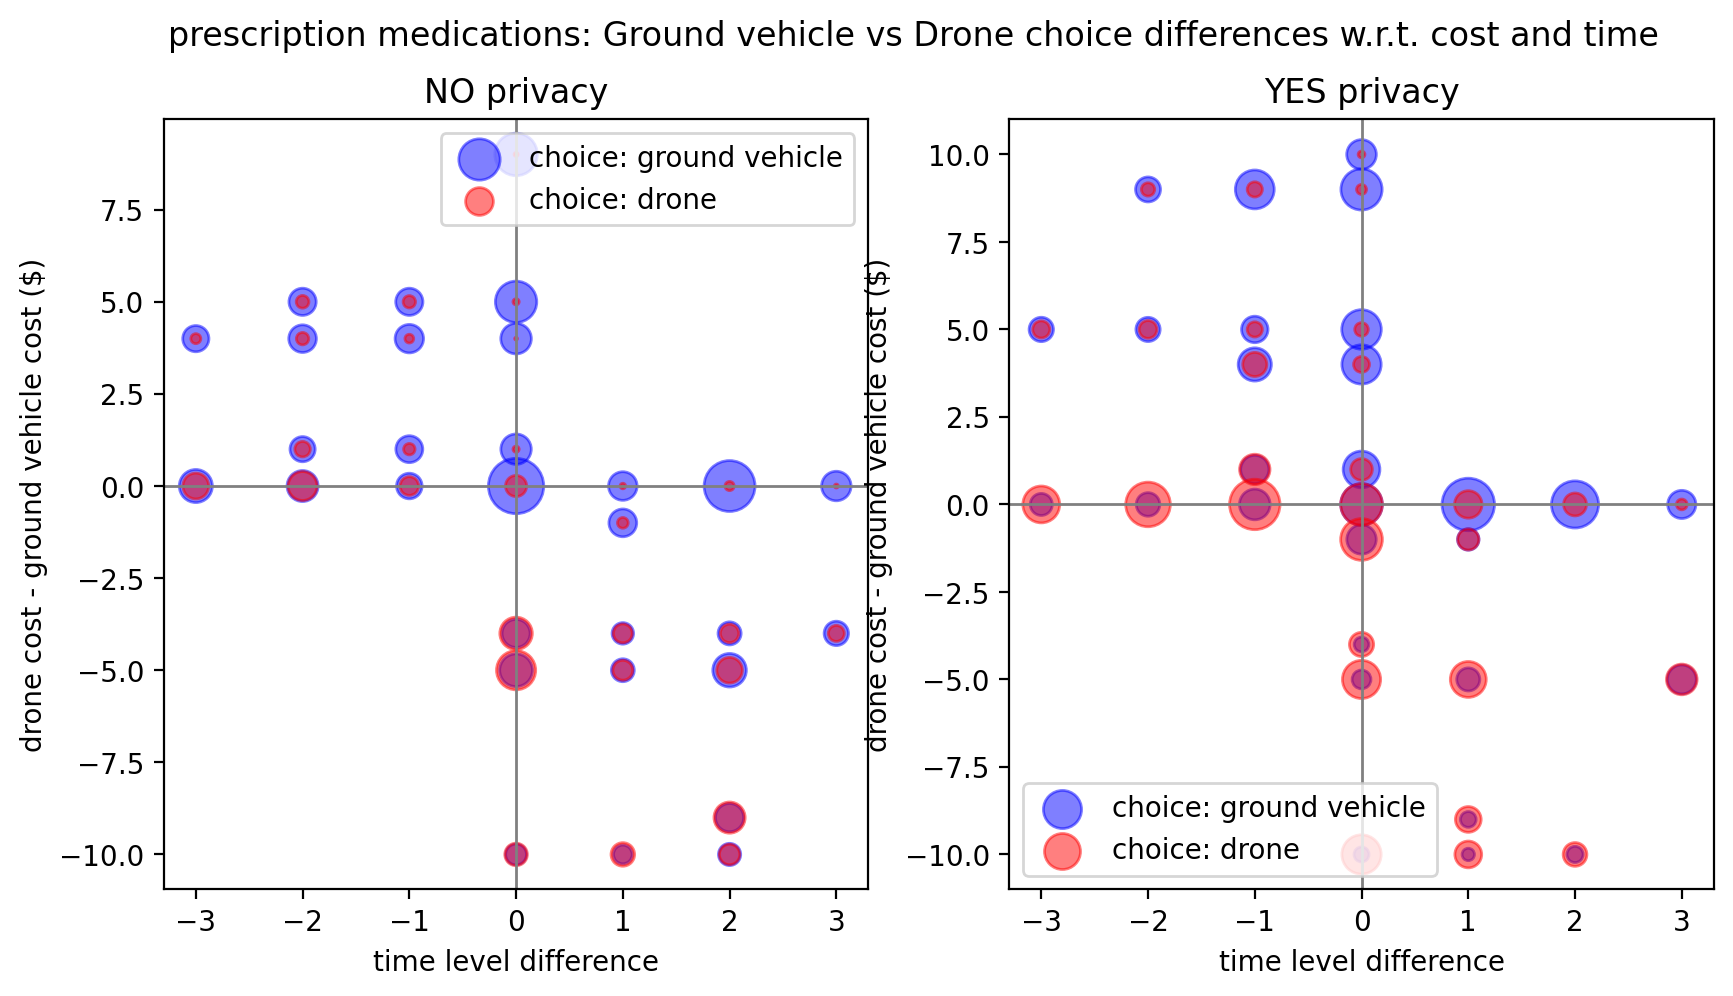

In [19]:
v=1
vdf = choices_df[choices_df['v']==v]
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0])
plt.show()
print('by difference in levels of time increments vs actual time')
plot_points_tradeoff_by_size(vdf, VENDOR_TYPES[v][0], use_levels=True)

## Dummy models



Note that this simple logistic regression model does NOT work when the time variables are in real minute values. But DOES work when they are in values by level.

With this information time levels in the biogeme models.

In [7]:
from pymer4.models import Lmer

In [8]:
usecols = [
    'choice',
    'dt_less_gt',
    'd_cost - g_cost',
    'd_privacy',
    'ResponseId'
]
v_choices_df = vdf[usecols]
formula = 'choice ~ dt_less_gt + d_cost_minus_g_cost + d_privacy + (1|ResponseId)'
m = Lmer(formula, data=v_choices_df.rename(columns={
        'd_cost - g_cost':'d_cost_minus_g_cost',
    }), family='binomial')
print(m.fit())

From cffi callback <function _processevents at 0x7fa718ae88c8>:
Traceback (most recent call last):
  File "/Users/aberke/projects/drones-consumer-privacy/drones-venv/lib/python3.7/site-packages/rpy2/rinterface_lib/callbacks.py", line 274, in _processevents
    @ffi_proxy.callback(ffi_proxy._processevents_def,
KeyboardInterrupt


Formula: choice~dt_less_gt+d_cost_minus_g_cost+d_privacy+(1|ResponseId)

Family: binomial	 Inference: parametric

Number of observations: 11481	 Groups: {'ResponseId': 3323.0}

Log-likelihood: -5643.257 	 AIC: 11296.513

Random effects:

                   Name    Var    Std
ResponseId  (Intercept)  2.473  1.573

No random effect correlations specified

Fixed effects:

                     Estimate  2.5_ci  97.5_ci     SE     OR  OR_2.5_ci  \
(Intercept)            -1.998  -2.125   -1.871  0.065  0.136      0.119   
dt_less_gt             -0.714  -0.764   -0.663  0.026  0.490      0.466   
d_cost_minus_g_cost    -0.400  -0.421   -0.379  0.011  0.670      0.656   
d_privacy               1.827   1.692    1.962  0.069  6.216      5.429   

                     OR_97.5_ci   Prob  Prob_2.5_ci  Prob_97.5_ci  Z-stat  \
(Intercept)               0.154  0.119        0.107         0.133 -30.891   
dt_less_gt                0.515  0.329        0.318         0.340 -27.731   
d_cost_minus_g_cost  

## Biogeme

Documentation: https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf


### Initial simple experiments

#### Generic vs alternative specific attributes.
We want to use alternative specific attributes, but start with generic.


#### Random coefficients
We want to model random effects/taste variation with a random parameter logit model. However, we start without this.


#### Iterative modeling process:

Start simplest, add complexity and use statistical tests to determine whether changes to the model add significant explanatory power.

Tests used:
- (baseline) verify parameters have expended signs
- (simplest) t-test: use t-test values and p-values to evaluate whether a parameter is statistically significant
- adjusted likelihood ratio index (rho bar squared) $\bar{\rho^2}$: evaluate whether adding a variable had a positive impact on this metric
- use likelihood ratio test

Modeling steps:

- generic model without free parameter
- add free paramter and test whether it adds statistically siginicant explanatory power
- test alternatve specific time parameter
- test alternative specific cost parameter
- -- not for now: test impact of random coefficients
    - this is not done in related work by Haan et al (2021); complicates estimation of VOT?

- test addition of consumer behavior and interactions with privacy parameter:
    - dummy variables:
        - online shopping more than 1x/week
        - take-out food delivery more than 1x/week
- test addition of socioeconomic variables and interactions with privacy parameter:
    - gender
    - age: dummy variable for older; dummy variable for younger
    - residential type: dummy variables:
        - private home, apartment
    - residential area: dummy:
        - urban, suburban, rural

#### Test with $\bar{\rho^2}$

Ben Akiva & Lerman (1985):

For the same estimation data set, the $\rho^2$ of a model always increases or at least stays the same whenever new variables are added to the model, a limitation it shares with regression statistic $R^2$. For this reason we also use the adjusted likelihood ratio index (rho bar squared):

$$
\bar{\rho^2} = 1 - \frac{L(\tilde{\beta}) - K }{L(0)}
$$
where K denotes the number of unknown parameters in the model.

#### Test with likelihood ratio test: generic vs alternative-specific attributes

Specify models with both generic and alternative-specific attributes.

Then use the likelihood ratio test (pages 28 and 164-167 in Ben Akiva & Lerman (1985)) to test which model specification should be used.

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e. for cost and time:

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$ & $\beta_{g\_time} = \beta_{d\_time}$

The test statistic for the null hypothesis is 

$-2(L_R - L_U)$

which is asymtotically distributed as $X^2$ with $df = K_U - K_R$ degrees of freedom, where $K_U$, $K_R$ are the number of estimated parameters in the unrestricted and restricted models.

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom.

In [20]:
import biogeme.database as db
import biogeme.biogeme as bio
from biogeme import models
import biogeme.messaging as msg
from biogeme.expressions import (
    Beta,
    DefineVariable,
    bioDraws,
    PanelLikelihoodTrajectory,
    MonteCarlo,
    log,
)

In [21]:
model_choice_cols = [
    'ID',         # respondent ID - to model agent level effect
    
    'choice',     # 0=ground vehicle; 1=drone
    'd_privacy',  # 0=NO PRIVACY; 1=YES PRIVACY (for drone delivery)
    'g_cost',     # ground vehicle delivery cost
    'd_cost',     # drone delivery cost
    'g_free',
    'd_free',
    # NOTE THE DIFFERENCE HERE -- values are by level, not minutes
    'gt',         # ground vehicle delivery wait time
    'dt',         # drone delivery wait time
    
    # dummy coded (0/1)
    'male',       # 1=male; 0=otherwise
    'race_white', 'race_black', 'race_asian', 'race_other_or_mixed',
    'age_young', 'age_old',
    'income_lower', 'income_med', 'income_higher',
    'residence_house', 'residence_apartment',
    'urban', 'suburban', 'rural',
    
    'freq_ecommerce',
    'freq_takeout_food',
]

In [22]:
def get_vendor_panel_database(v, name=None):
    """Returns new fresh database each time."""
    db_name = name if name else 'v%s'%v
    df = choices_df[choices_df['v']==v][model_choice_cols]
    database = db.Database(db_name, df)
    database.panel('ID')
    return database

In [23]:
database = get_vendor_panel_database(v)
database.data.head()

,ID,choice,d_privacy,g_cost,d_cost,g_free,d_free,gt,dt,male,...,income_lower,income_med,income_higher,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food
0,0,1,0,10,0,0,1,0,2,1,...,0,0,1,0,1,1,0,0,0,1
1,0,0,1,0,1,1,0,0,0,1,...,0,0,1,0,1,1,0,0,0,1
2,0,1,0,5,1,0,0,0,1,1,...,0,0,1,0,1,1,0,0,0,1
3,1,1,1,1,1,0,0,1,0,0,...,0,0,1,1,0,0,1,0,0,0
4,1,0,1,1,5,0,0,2,1,0,...,0,0,1,1,0,0,1,0,0,0


In [24]:
# To use the names of variables as Python variables.
globals().update(database.variables)
# print(database.variables)
# The Pandas data structure is available as database.data. Use all the
# Pandas functions to invesigate the database
database.data.describe()

,ID,choice,d_privacy,g_cost,d_cost,g_free,d_free,gt,dt,male,...,income_lower,income_med,income_higher,residence_house,residence_apartment,urban,suburban,rural,freq_ecommerce,freq_takeout_food
count,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,...,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000,11481.000000
mean,1880.146851,0.378277,0.557704,4.088668,3.796708,0.182040,0.252417,1.536713,1.562669,0.482885,...,0.400314,0.370525,0.229161,0.714398,0.257904,0.262869,0.552652,0.179253,0.186308,0.058009
std,1069.919982,0.484978,0.496681,3.804931,3.808133,0.385894,0.434418,1.116661,1.106252,0.499729,...,0.489983,0.482966,0.420311,0.451720,0.437500,0.440211,0.497242,0.383580,0.389372,0.233770
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,979.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1885.000000,0.000000,1.000000,5.000000,1.000000,0.000000,0.000000,2.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,2801.000000,1.000000,1.000000,5.000000,5.000000,0.000000,1.000000,3.000000,3.000000,1.000000,...,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
max,3714.000000,1.000000,1.000000,10.000000,10.000000,1.000000,1.000000,3.000000,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [27]:
# https://transp-or.epfl.ch/documents/technicalReports/Bier20.pdf
# results.data.sampleSize: the sample size N.
# results.data.numberOfObservations: the number of rows in the data file. If the data is not panel, it is the same as the sample size.
# results.data.nparam: the number K of estimated parameters.
# results.data.logLike: the value L∗ of the log likelihood at the final value of the parameters.

# order how parameters are printed in this way; 
# accounting for when parameters are alternative specific or not, or included or not
param_order = [
    'ASC_G', 'ASC_D', 'ASC_G_MEAN', 'ASC_G_S', 'ASC_D_MEAN', 'ASC_D_S', 
    'B_TIME', 'B_G_TIME','B_D_TIME',
    'B_COST', 'B_G_COST', 'B_D_COST',
    'B_FREE',
    'B_DPRIVACY',
     # consumer attributes
    'B_FREQ_ECOMMERCE', 'B_FREQ_ECOMMERCE_PRIVACY', 
    'B_FREQ_TAKEOUT_FOOD', 'B_FREQ_TAKEOUT_FOOD_PRIVACY',
    # gender
    'B_MALE', 'B_MALE_PRIVACY',
    # race
    'B_RACE_WHITE', 'B_RACE_BLACK', 'B_RACE_ASIAN', 'B_RACE_OTHER_OR_MIXED',
    # age
    'B_AGE_YOUNG', 'B_AGE_YOUNG_PRIVACY',
    'B_AGE_OLD', 'B_AGE_OLD_PRIVACY',
    # income
    'B_INCOME_LOWER', 'B_INCOME_LOWER_PRIVACY',
    'B_INCOME_MED', 'B_INCOME_MED_PRIVACY',
    'B_INCOME_HIGHER', 'B_INCOME_HIGHER_PRIVACY',
    # residence
    'B_RESIDENCE_APARTMENT', 'B_RESIDENCE_APARTMENT_PRIVACY',
    'B_RESIDENCE_HOUSE', 'B_RESIDENCE_HOUSE_PRIVACY', 
    'B_RURAL', 'B_RURAL_PRIVACY', 
    'B_SUBURBAN', 'B_SUBURBAN_PRIVACY', 
    'B_URBAN', 'B_URBAN_PRIVACY',
]

def print_biogeme_results(results, display_pvalues=True, print_params=None):
    print('Model: %s' % results.data.modelName)
    print('\n---- Coefficients ----')
    params_df = results.getEstimatedParameters()
    params_df[''] = params_df['Rob. p-value'].apply(lambda p: '**' if p<0.01 else ('*' if p<0.05 else ''))
    # make a column that consolidates the p-value * and estimated Value
    params_df['Est.'] = params_df.apply(lambda row: '%0.3f%s' % (row['Value'], row['']), axis=1)
    params_df = params_df[
        ['Est.', 'Rob. Std err'] + (['Rob. p-value'] if display_pvalues else [])
    ].round(3)
    # get rid of trailing zeros from rounding
    params_df['Rob. Std err'] = params_df['Rob. Std err'].apply(lambda se: '%0.3f'%se)
    params_df = params_df.reindex([p for p in param_order if p in params_df.index])
    if print_params is not None:
        params_df = params_df.reindex(print_params).fillna('')
    display(params_df)
    print('\n---- Model statistics ----\n')
    stats = [
        'Sample size','Observations',
        'Number of estimated parameters',
        'Number of draws',
        'Init log likelihood','Final log likelihood',
        'Rho-square-bar for the init. model',
        'Akaike Information Criterion','Bayesian Information Criterion'
    ]
    model_stats = results.getGeneralStatistics()
    model_stats_df = pd.DataFrame({k: [v] for k, (v, _) in model_stats.items()})[
        [c for c in stats if c in model_stats.keys()]
    ].transpose()[[0]].round(3).rename(columns={0:'Value'})
    display(model_stats_df)
    return params_df, model_stats_df

### Simplest generic model

In [39]:
# without the random utility model we estimate models without using PanelLikelihoodTrajectory
# This is based on instruction from Professor Bierlaire (Biogeme author)
# see https://groups.google.com/g/biogeme/c/1CDNIpQoGPw

In [40]:
"""
Generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * gt
V_drone =  B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy
(drone used as reference for ASC's)
"""

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
ASC_G = Beta('ASC_G', 0, None, None, 0)
ASC_D = Beta('ASC_D', 0, None, None, 1) # 1: this will not change and will make this the reference for ASC's
B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
logprob = models.loglogit(V, av, choice)
# Create the Biogeme object
biogeme = bio.BIOGEME(database, logprob)
biogeme.modelName = 'v%s_generic_logit_1'%v
# Calculate the null log likelihood for reporting.
biogeme.calculateNullLoglikelihood(av)
# Estimate the parameters
generic_logit_results = biogeme.estimate()
params_df, model_stats_df = print_biogeme_results(generic_logit_results)

[17:39:21] < Warning >   Cannot read file __v1_generic_logit_1.iter. Statement is ignored.
Model: v1_generic_logit_1

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_G,1.389**,0.069,0.0
B_TIME,-0.556**,0.034,0.0
B_COST,-0.293**,0.013,0.0
B_DPRIVACY,1.258**,0.089,0.0



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,4.000
Init log likelihood,-2303.328
Final log likelihood,-1759.071
Rho-square-bar for the init. model,0.235
Akaike Information Criterion,3526.141
Bayesian Information Criterion,3550.576


In [41]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)

betas = generic_logit_results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST ($1/1 minute)
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % (vop*-1))

VOT ($) for ground vehicle: 1.90
how to evaluate value of privacy?
value of privacy ($) for drone: 4.29


### Alternative specific variance

We have panel data and reason to assume that the preference for drone/ground delivery is highly variable among individuals and should capture that agent level effect. We do this by specifying an alternative specific variance model.

Here the parameters for time, cost, and the ASC's are randomly
distributed with a normal distribution.

For the ASCs:
The normalization is not arbitrary. Only the minimum variance alternative should be normalized to 0. Therefore, proper estimation first requires the unidentified model be estimated (with all 2 variances in this case). Then the model should be re-estimated with the smallest variance from the unidentified model normalized to 0.

We therefore do this in 2 stages below.

1. Estimate all variances
2. Fix minimum variance alternative to 0. Also use the parameter values from (1) as starting values for faster estimation.

For 1,2, see Biogeme's files for example: 12panel, [13panel (changed)](https://github.com/michelbierlaire/biogeme/blob/ce360416aedf145b8b93024aef173c6701ac4159/examples/swissmetro/13panelNormalized.ipynb).

In [26]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = ASC_g + B_cost * g_cost + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

1. estimate all ASC variances to identify minimum variance alternative.

"""
database = get_vendor_panel_database(v)
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
ASC_G_MEAN = Beta('ASC_G_MEAN', 0, None, None, 1) # initially fixed as reference
ASC_G_S = Beta('ASC_G_S', 1, None, None, 0)
ASC_G = ASC_G_MEAN + ASC_G_S * bioDraws('ASC_G_RND', 'NORMAL_ANTI')

ASC_D_MEAN = Beta('ASC_D_MEAN', 0, None, None, 0)
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = ASC_G + B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'Initial estimation of model with alternative specific variance. '
        'Rerun this model where the minimum variance ASC is fixed to 0.'
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_1'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

start time: 17:34:52
end time: 17:35:21
Model: v1_generic_logit_asc_variance_1

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_G_S,-1.659**,0.095,0.000
ASC_D_MEAN,-2.028**,0.070,0.000
ASC_D_S,0.322,0.344,0.349
B_TIME,-0.724**,0.027,0.000
B_COST,-0.406**,0.012,0.000
B_DPRIVACY,1.855**,0.076,0.000



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,6.000
Number of draws,100.000
Init log likelihood,-7555.750
Final log likelihood,-5607.316
Rho-square-bar for the init. model,0.257
Akaike Information Criterion,11226.632
Bayesian Information Criterion,11263.284


The variance for ground vehicle is smaller.

This is convenient since this is the same as for v0.

We estimate the models with the ground vehicle ASC normalized to 0.

For completeness, we continue with step 2.

In [28]:
"""
Alternative specific variance generic logit model
(free is not an attribute)

V_groundvehicle = B_cost * g_cost + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_time * dt + B_dprivacy * d_privacy

The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

2. Fix minimum variance alternative to 0. 
Also use the parameter values from (1) as starting values for faster estimation.

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated

# Define random parameters, normally distributed across individuals,
# designed to be used for Monte-Carlo simulation
# ASC_G_MEAN normalized to 0
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

# Definition of the model. This is the contribution of each
# observation to the log likelihood function.
# Conditional to the random parameters, the likelihood of one observation
obsprob = models.logit(V, av, choice)
# Conditional to the random parameters, the likelihood of all observations for
# one individual (the trajectory) is the product of the likelihood of
# each observation.
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
# We integrate over the random parameters using Monte-Carlo
logprob = log(MonteCarlo(condprobIndiv))

biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'Second estimation of model with alternative specific variance. '
    )
)
biogeme.modelName = 'v%s_generic_logit_asc_variance_2'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

start time: 17:40:24
end time: 17:40:39
Model: v1_generic_logit_asc_variance_2

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.025**,0.070,0.0
ASC_D_S,-1.677**,0.065,0.0
B_TIME,-0.721**,0.027,0.0
B_COST,-0.405**,0.012,0.0
B_DPRIVACY,1.849**,0.076,0.0



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,5.000
Number of draws,100.000
Init log likelihood,-8631.438
Final log likelihood,-5612.786
Rho-square-bar for the init. model,0.349
Akaike Information Criterion,11235.572
Bayesian Information Criterion,11266.115


In [29]:
# estimated value of time:
# B_TIME/B_COST ($1/1 minute)

betas = results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST ($1)
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % vop)

VOT ($) for ground vehicle: 1.78
how to evaluate value of privacy?
value of privacy ($) for drone: -4.57


#### Results overview

The VOT barely changed (good).

The $\bar{\rho^2}$ is improved over the model without the alternative specific variance -- indicating the alternative specific variance model is an improvement.


### Adding a coefficient for free

In [30]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""

database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0)
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_TIME*gt
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'test free after alternative specific variance'
    )
)
biogeme.modelName = 'v%s_generic_asv_free'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(results)

start time: 17:41:00
end time: 17:41:20
Model: v1_generic_asv_free

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.021**,0.070,0.0
ASC_D_S,-1.683**,0.066,0.0
B_TIME,-0.730**,0.027,0.0
B_COST,-0.390**,0.012,0.0
B_FREE,0.246**,0.064,0.0
B_DPRIVACY,1.825**,0.076,0.0



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,6.000
Number of draws,100.000
Init log likelihood,-8631.438
Final log likelihood,-5605.293
Rho-square-bar for the init. model,0.350
Akaike Information Criterion,11222.587
Bayesian Information Criterion,11259.238


In [31]:
betas = results.getBetaValues()

# estimated value of time:
# B_TIME/B_COST
vot = betas['B_TIME']/betas['B_COST']
print('VOT ($): %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = -1*betas['B_DPRIVACY']/betas['B_COST']
print('value of privacy ($) for drone: %0.2f' % vop)
# B_PRIVACY/B_COST

VOT ($): 1.87
how to evaluate value of privacy?
value of privacy ($) for drone: 4.68


#### Results

Overall, adding a coefficient to represent whether delivery is free seems to improve the model.

- free coefficient statistically significant
- slightly improved value for $\bar{\rho^2}$
- VOT barely changed even though free is statistically significant


### Modeling with alternative-specific attributes

We use above model with generic time and cost coefficients as the restricted model.

We then test a (unrestricted model) specification with alternative specific cost coefficient.

In [32]:
# get previous model results (restricted model) for comparison
restricted_results = results

#### Test alternative specific time coefficient

Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_time} = \beta_{d\_time}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [33]:
"""
V_groundvehicle = B_cost * g_cost + B_free * g_free + B_g_time * gt
V_drone =  ASC_d + B_cost * d_cost + B_free * d_free + B_d_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
time coefficient is alternative specific

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_COST = Beta('B_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_G_TIME = Beta('B_G_TIME', 0, None, None, 0)
B_D_TIME = Beta('B_D_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_COST*g_cost + B_FREE*g_free + B_G_TIME*gt
VD = ASC_D + B_COST*d_cost + B_FREE*d_free + B_D_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'test alternative specific time coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_time'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(unrestricted_results)

start time: 17:42:39
end time: 17:42:58
Model: v1_as_time

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.014**,0.091,0.0
ASC_D_S,1.683**,0.066,0.0
B_G_TIME,-0.728**,0.034,0.0
B_D_TIME,-0.732**,0.032,0.0
B_COST,-0.390**,0.012,0.0
B_FREE,0.247**,0.066,0.0
B_DPRIVACY,1.825**,0.076,0.0



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,7.000
Number of draws,100.000
Init log likelihood,-8631.438
Final log likelihood,-5605.286
Rho-square-bar for the init. model,0.350
Akaike Information Criterion,11224.573
Bayesian Information Criterion,11267.333


Perform the likelihood ratio test

In [34]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_2,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=0.0138
X_2,0.05 = 3.84
cannot reject the null hypothesis


#### Test alternative specific cost coefficient


Define the restricted model (generic attributes) and unrestricted model (alternative-specific attributes): $M_R$, $M_U$

Test null hypothesis. i.e.

$H_0$ : $\beta_{g\_cost} = \beta_{d\_cost}$

Reject the null hypothesis that the restrictions are true if 

$-2(L_R - L_U) > X^2_{((1-\alpha),df)}$

where $\alpha$ is the level of significance (use $\alpha=0.05$) and df is degrees of freedom. Here df=1

In [36]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
    
cost coefficient is alternative specific

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -2, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_G_COST*g_cost + B_FREE*g_free + B_TIME*gt
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*dt + B_DPRIVACY*d_privacy 

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'test alternative specific cost coefficient with alternative specific variance + free'
    )
)
biogeme.modelName = 'v%s_as_cost'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
unrestricted_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(unrestricted_results)

start time: 17:43:32
end time: 17:43:44
Model: v1_as_cost

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-1.867**,0.077,0.0
ASC_D_S,1.686**,0.066,0.0
B_TIME,-0.729**,0.027,0.0
B_G_COST,-0.369**,0.013,0.0
B_D_COST,-0.415**,0.014,0.0
B_FREE,0.248**,0.064,0.0
B_DPRIVACY,1.854**,0.076,0.0



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,7.000
Number of draws,100.000
Init log likelihood,-5658.156
Final log likelihood,-5594.611
Rho-square-bar for the init. model,0.010
Akaike Information Criterion,11203.222
Bayesian Information Criterion,11245.982


Perform the likelihood ratio test

In [37]:
K_R = restricted_results.data.nparam
K_U = unrestricted_results.data.nparam
df = K_U - K_R
print('df=%s'%df)

L_R = restricted_results.data.logLike
L_U = unrestricted_results.data.logLike
test_stat = -2*(L_R - L_U)
print('−2(L_R - L_U)=%0.4f' % test_stat)
print('X_1,0.05 = 3.84')
if test_stat > 3.84:
    print('can reject the null hypothesis')
else:
    print('cannot reject the null hypothesis')

df=1
−2(L_R - L_U)=21.3649
X_1,0.05 = 3.84
can reject the null hypothesis


#### Results

- LLR Test indicates time NOT alternative specific
- LLR Test *very much* indicates cost is alternative specific
- $\bar{\rho^2}$ is slightly improved with alternative specific cost

### Consumer behavior attributes and interactions with privacy parameter

We add in the following parameters. Positively estimated coefficients will indicate a positive relationship between these parameters and drone preference.

- freq_ecommerce: online shopping more than 1x/week (0/1)
- freq_takeout_food: take-out food delivery more than 1x/week

In [38]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * dt + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce 
    + B_freq_ecommerce_privacy * freq_ecommerce * d_privacy
    + B_freq_takeout_food * freq_takeout_food 
    + B_freq_takeout_food_privacy * freq_takeout_food * d_privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free
"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)
# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -1.8, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)
B_FREQ_ECOMMERCE_PRIVACY = Beta('B_FREQ_ECOMMERCE_PRIVACY', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD = Beta('B_FREQ_TAKEOUT_FOOD', 0, None, None, 0)
B_FREQ_TAKEOUT_FOOD_PRIVACY = Beta('B_FREQ_TAKEOUT_FOOD_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = ASC_G + B_G_COST*g_cost + B_FREE*g_free + B_TIME*gt

VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*dt \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_FREQ_ECOMMERCE_PRIVACY*freq_ecommerce*d_privacy \
    + B_FREQ_TAKEOUT_FOOD*freq_takeout_food \
    + B_FREQ_TAKEOUT_FOOD_PRIVACY*freq_takeout_food*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Create the Biogeme object
biogeme = bio.BIOGEME(
    database, 
    logprob,
    userNotes=(
        'test with consumer behavior variables'
    )
)
biogeme.modelName = 'v%s_freq_consumer'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
cons_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(cons_results)

start time: 17:44:24
end time: 17:45:29
Model: v1_freq_consumer

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_G_S,1.656**,0.106,0.000
ASC_D_MEAN,-1.939**,0.083,0.000
ASC_D_S,-0.338,0.388,0.383
B_TIME,-0.732**,0.028,0.000
B_G_COST,-0.370**,0.013,0.000
B_D_COST,-0.416**,0.014,0.000
B_FREE,0.252**,0.064,0.000
B_DPRIVACY,1.887**,0.085,0.000
B_FREQ_ECOMMERCE,0.341*,0.147,0.020
B_FREQ_ECOMMERCE_PRIVACY,-0.276,0.176,0.117



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,12.000
Number of draws,100.000
Init log likelihood,-7972.440
Final log likelihood,-5582.559
Rho-square-bar for the init. model,0.298
Akaike Information Criterion,11189.119
Bayesian Information Criterion,11262.422


#### Results overview

- freq ecommerce only statistically significant coefficient.
- ppl who most frequently order ecommerce more likely to prefer drone

Continue without take-out food parameters and without freq ecommerce x privacy

### Demographic variables and interactions with privacy parameter

We add in the following parameters. Positively estimated coefficients will indicate a positive relationship between these parameters and drone preference.

- gender: male/other (1/0)
- race: white, black, asian, other or mixed (0/1)
    - exclude white to use as reference variable
- age: age_young, age_old (0/1)
- income: lower, medium, higher (0/1)
    - only include lower, higher
- residential type: residence_house (0/1)
- residential area: urban, suburban, rural (0/1)
    only include 2: urban, suburban

In [43]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * g_time
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * d_time 
    + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_male * male + B_gender_privacy * gender * d_privacy
    + B_race_black * race_black + B_race_asian * race_asian + B_race_other_or_mixed * race_other_or_mixed
    + B_age_young * age_young + B_age_old * age_old
    + B_income_lower * income_lower + B_income_higher * income_higher
    + B_residence_house * residence_house
    + B_urban * urban 
    + B_suburban * suburban 
    + [demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
database = get_vendor_panel_database(v)
# To use the names of variables as Python variables.
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -1.8, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

# Race: White is used as reference variable
B_RACE_BLACK = Beta('B_RACE_BLACK', 0, None, None, 0)
B_RACE_ASIAN = Beta('B_RACE_ASIAN', 0, None, None, 0)
B_RACE_OTHER_OR_MIXED = Beta('B_RACE_OTHER_OR_MIXED', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_INCOME_LOWER = Beta('B_INCOME_LOWER', 0, None, None, 0)
B_INCOME_HIGHER = Beta('B_INCOME_HIGHER', 0, None, None, 0)
B_INCOME_LOWER_PRIVACY = Beta('B_INCOME_LOWER_PRIVACY', 0, None, None, 0)
B_INCOME_HIGHER_PRIVACY = Beta('B_INCOME_HIGHER_PRIVACY', 0, None, None, 0)

B_RESIDENCE_HOUSE = Beta('B_RESIDENCE_HOUSE', 0, None, None, 0)
B_RESIDENCE_HOUSE_PRIVACY = Beta('B_RESIDENCE_HOUSE_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)
# B_RURAL = Beta('B_RURAL', 0, None, None, 0)
B_URBAN_PRIVACY = Beta('B_URBAN_PRIVACY', 0, None, None, 0)
B_SUBURBAN_PRIVACY = Beta('B_SUBURBAN_PRIVACY', 0, None, None, 0)
# B_RURAL_PRIVACY = Beta('B_RURAL_PRIVACY', 0, None, None, 0)

# Definition of the utility functions
VG = B_G_COST*g_cost + B_FREE*g_free + B_TIME*gt

VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*dt \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_RACE_BLACK*race_black + B_RACE_ASIAN*race_asian + B_RACE_OTHER_OR_MIXED*race_other_or_mixed \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_INCOME_LOWER*income_lower + B_INCOME_LOWER_PRIVACY*income_lower*d_privacy \
    + B_INCOME_HIGHER*income_higher + B_INCOME_HIGHER_PRIVACY*income_higher*d_privacy \
    + B_RESIDENCE_HOUSE*residence_house + B_RESIDENCE_HOUSE_PRIVACY*residence_house*d_privacy \
    + B_URBAN*urban + B_URBAN_PRIVACY*urban*d_privacy \
    + B_SUBURBAN*suburban + B_SUBURBAN_PRIVACY*suburban*d_privacy

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

biogeme = bio.BIOGEME(
    database,
    logprob,
    userNotes=(
        'test with socioeconomic variables'
    )
)
biogeme.modelName = 'v%s_demographics'%v
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
demo_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params_df, model_stats_df = print_biogeme_results(demo_results)

start time: 18:08:21
end time: 18:09:32
Model: v1_demographics

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.459**,0.241,0.000
ASC_D_S,1.660**,0.066,0.000
B_TIME,-0.737**,0.028,0.000
B_G_COST,-0.372**,0.013,0.000
B_D_COST,-0.419**,0.014,0.000
B_FREE,0.240**,0.064,0.000
B_DPRIVACY,2.130**,0.281,0.000
B_FREQ_ECOMMERCE,0.280**,0.104,0.007
B_MALE,0.798**,0.118,0.000
B_MALE_PRIVACY,-0.314*,0.139,0.025



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,27.000
Number of draws,100.000
Init log likelihood,-5529.447
Final log likelihood,-5528.317
Rho-square-bar for the init. model,-0.005
Akaike Information Criterion,11110.634
Bayesian Information Criterion,11275.567


In the above model, residence type has no significance, but residence area: urban does.

- race demographics insignificant
- age-young not significant, but age-young x privacy is significant
- income level not significant


### Estimating a final model

After reviewing the significant coefficients from the models estimated for each vendor type, we choose a model specification that uses consistent consumer group variables across the models. 

These variables are chosen to represent variables that were statistically significant in models for at least one vendor.


Frequent e-commerce use
- alone statistically significant in models for multiple vendors
- interaction effect x privacy not significant

Residential area
- urban statistically significant in multiple models
- interaction effect x privacy NOT significant in any model - not included

In [57]:
"""
V_groundvehicle = B_g_cost * g_cost + B_free * g_free + B_time * gt
V_drone =  ASC_d + B_d_cost * d_cost + B_free * d_free + B_time * dt
    + B_dprivacy * d_privacy
    + B_freq_ecommerce * freq_ecommerce
    + B_male * male + B_male_privacy * male * d_privacy
    + B_age_young * age_young + B_age_old * age_old
    + B_urban * urban 
    + B_suburban * suburban
    + [age demographics] * privacy


The parameters for the ASC's, time and cost are randomly distributed 
across the population with a normal distribution.

g_free/d_free are dummy variables indicating whether there is a delivery cost:
    0=not free; 1=free

"""
database = get_vendor_panel_database(v)
globals().update(database.variables)

# Parameters to be estimated
# ASC_G_MEAN fixed as reference
ASC_D_MEAN = Beta('ASC_D_MEAN', -1.8, None, None, 0) 
ASC_D_S = Beta('ASC_D_S', 1, None, None, 0)
ASC_D = ASC_D_MEAN + ASC_D_S * bioDraws('ASC_D_RND', 'NORMAL_ANTI')

B_G_COST = Beta('B_G_COST', 0, None, None, 0)
B_D_COST = Beta('B_D_COST', 0, None, None, 0)
B_FREE = Beta('B_FREE', 0, None, None, 0) # assumed generic for now
B_TIME = Beta('B_TIME', 0, None, None, 0)
B_DPRIVACY = Beta('B_DPRIVACY', 0, None, None, 0)

# consumer behavior variables
B_FREQ_ECOMMERCE = Beta('B_FREQ_ECOMMERCE', 0, None, None, 0)

# socioeconomic variables
B_MALE = Beta('B_MALE', 0, None, None, 0)
B_MALE_PRIVACY = Beta('B_MALE_PRIVACY', 0, None, None, 0)

B_AGE_YOUNG = Beta('B_AGE_YOUNG', 0, None, None, 0)
B_AGE_OLD = Beta('B_AGE_OLD', 0, None, None, 0)
B_AGE_YOUNG_PRIVACY = Beta('B_AGE_YOUNG_PRIVACY', 0, None, None, 0)
B_AGE_OLD_PRIVACY = Beta('B_AGE_OLD_PRIVACY', 0, None, None, 0)

B_URBAN = Beta('B_URBAN', 0, None, None, 0)
B_SUBURBAN = Beta('B_SUBURBAN', 0, None, None, 0)

# Definition of the utility functions
VG = B_G_COST*g_cost + B_FREE*g_free + B_TIME*gt
VD = ASC_D + B_D_COST*d_cost + B_FREE*d_free + B_TIME*dt \
    + B_DPRIVACY*d_privacy \
    + B_FREQ_ECOMMERCE*freq_ecommerce \
    + B_MALE*male + B_MALE_PRIVACY*male*d_privacy \
    + B_AGE_YOUNG*age_young + B_AGE_OLD*age_old \
    + B_AGE_YOUNG_PRIVACY*age_young*d_privacy + B_AGE_OLD_PRIVACY*age_old*d_privacy \
    + B_URBAN*urban \
    + B_SUBURBAN*suburban

# Associate utility functions with the numbering of alternatives
V = {0: VG, 1: VD}
# Associate the availability conditions with the alternatives
av = {0: 1, 1: 1}

obsprob = models.logit(V, av, choice)
condprobIndiv = PanelLikelihoodTrajectory(obsprob)
logprob = log(MonteCarlo(condprobIndiv))

# Define level of verbosity
msg.bioMessage().setWarning() # .setGeneral() .setDetailed() << other options for messages

draws = 5000
biogeme = bio.BIOGEME(
    database, 
    logprob,
    numberOfDraws=draws,
    seed=12, # use a consistent seed for consistent results
    userNotes=(
        'Final v1 model estimation'
    )
)
biogeme.modelName = 'v%s_final'%v
print('%s draws' % draws)
print('start time: %s' % time.strftime("%H:%M:%S", time.localtime()))
# Estimate the parameters
final_results = biogeme.estimate()
print('end time: %s' % time.strftime("%H:%M:%S", time.localtime()))
params, model_stats = print_biogeme_results(final_results)

5000 draws
start time: 11:25:43
[11:25:43] < Warning >   Cannot read file __v1_final.iter. Statement is ignored.
end time: 17:44:32
Model: v1_final

---- Coefficients ----


,Est.,Rob. Std err,Rob. p-value
ASC_D_MEAN,-2.251**,0.156,0.000
ASC_D_S,1.668**,0.066,0.000
B_TIME,-0.740**,0.028,0.000
B_G_COST,-0.374**,0.013,0.000
B_D_COST,-0.422**,0.014,0.000
B_FREE,0.247**,0.064,0.000
B_DPRIVACY,1.868**,0.139,0.000
B_FREQ_ECOMMERCE,0.262*,0.103,0.011
B_MALE,0.814**,0.118,0.000
B_MALE_PRIVACY,-0.324*,0.140,0.021



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,16.000
Number of draws,5000.000
Init log likelihood,-8298.056
Final log likelihood,-5528.740
Rho-square-bar for the init. model,0.332
Akaike Information Criterion,11089.481
Bayesian Information Criterion,11187.219


In [71]:
betas = final_results.getBetaValues()
# estimated value of time:
# B_TIME/B_COST
vot = betas['B_TIME']/betas['B_G_COST']
print('VOT ($) for ground vehicle: %0.2f' % vot)
vot = betas['B_TIME']/betas['B_D_COST']
print('VOT ($) for drone: %0.2f' % vot)

print('how to evaluate value of privacy?')
vop = -1*betas['B_DPRIVACY']/betas['B_D_COST']
print('cost value for drone privacy ($): %0.2f' % vop)


VOT ($) for ground vehicle: 1.98
VOT ($) for drone: 1.76
how to evaluate value of privacy?
cost value for drone privacy ($): 4.43


Get the results for exporting to a table

In [63]:
# for each exporting to table with all model results, print out a consistent list of 
# parameters. This includes rows of white space
print_params = [
    'ASC_G', 'ASC_D_MEAN', 'ASC_D_S', 
    '',
    'B_TIME', 'B_G_TIME','B_D_TIME',
    '',
    'B_COST', 'B_G_COST', 'B_D_COST',
    'B_FREE',
    'B_DPRIVACY',
     # consumer attributes
    'consumer attributes',
    'B_FREQ_ECOMMERCE',
    'gender',
    # gender
    'B_MALE', 'B_MALE_PRIVACY',
    # age
    'age',
    'B_AGE_YOUNG', 'B_AGE_YOUNG_PRIVACY',
    'B_AGE_OLD', 'B_AGE_OLD_PRIVACY',
    # residence
    'residential area',
    'B_SUBURBAN','B_URBAN',
]

params_df, model_stats_df = print_biogeme_results(final_results, 
                                                  display_pvalues=False, 
                                                  print_params=print_params)

Model: v1_final

---- Coefficients ----


,Est.,Rob. Std err
ASC_G,,
ASC_D_MEAN,-2.251**,0.156
ASC_D_S,1.668**,0.066
,,
B_TIME,-0.740**,0.028
B_G_TIME,,
B_D_TIME,,
,,
B_COST,,
B_G_COST,-0.374**,0.013



---- Model statistics ----



,Value
Sample size,3323.000
Observations,11481.000
Number of estimated parameters,16.000
Number of draws,5000.000
Init log likelihood,-8298.056
Final log likelihood,-5528.740
Rho-square-bar for the init. model,0.332
Akaike Information Criterion,11089.481
Bayesian Information Criterion,11187.219


In [64]:
display(params_df[['Est.', 'Rob. Std err']].style.hide_index())

Est.,Rob. Std err
,
-2.251**,0.156
1.668**,0.066
,
-0.740**,0.028
,
,
,
,
-0.374**,0.013


In [69]:
display(model_stats_df.style.hide_index())

Value
3323.000000
11481.000000
16.000000
5000.000000
-8298.056000
-5528.740000
0.332000
11089.481000
11187.219000
